<a href="https://colab.research.google.com/github/prateekjoshi565/Fine-Tuning-BERT/blob/master/Fine_Tuning_BERT_for_Spam_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Transformers Library

In [30]:
!wget https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/train_stances.csv
!wget https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/train_bodies.csv
!wget https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/competition_test_bodies.csv
!wget https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/competition_test_stances.csv

--2022-08-01 09:06:03--  https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/train_stances.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4255300 (4.1M) [text/plain]
Saving to: ‘train_stances.csv.1’

train_stances.csv.1 100%[===================>]   4.06M  --.-KB/s    in 0.05s   

2022-08-01 09:06:03 (89.8 MB/s) - ‘train_stances.csv.1’ saved [4255300/4255300]

--2022-08-01 09:06:04--  https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/train_bodies.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3

In [2]:
!pip install transformers

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU


# Load Dataset

In [2]:
data_bodies = pd.read_csv("competition_test_bodies.csv")
data_stances = pd.read_csv("competition_test_stances.csv")



In [3]:

data = data_stances.join(data_bodies.set_index("Body ID"), on="Body ID")
# test_data = test_stances.join(test_bodies.set_index("Body ID"), on="Body ID")


In [4]:
cols = ['Headline', 'articleBody']
stance_dict = {"agree":0,"disagree":1,"discuss":2  ,"unrelated" :3}
data['text'] = data[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
data['label'] = data['Stance'].apply(lambda val:stance_dict[val] )

In [5]:
selected_features = ['text','label']
df = data.loc[:, data.columns.isin(selected_features)]

In [6]:
df.shape


(49972, 2)

In [7]:
df.head()


,text,label
0,Police find mass graves with at least '15 bodi...,3
1,Hundreds of Palestinians flee floods in Gaza a...,0
2,"Christian Bale passes on role of Steve Jobs, a...",3
3,HBO and Apple in Talks for $15/Month Apple TV ...,3
4,Spider burrowed through tourist's stomach and ...,1


In [8]:
# check class distribution
df['label'].value_counts(normalize = True)

3    0.731310
2    0.178280
0    0.073601
1    0.016809
Name: label, dtype: float64

# Split train dataset into train, validation and test sets

In [18]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [ ]:
# train_headline, temp_headline, train_body, temp_body, train_labels, temp_labels = train_test_split(df['Headline'], df['articleBody'],
#                                                                     df['Stance'], 
#                                                                     random_state=2018, 
#                                                                     test_size=0.3, 
#                                                                     stratify=df['Stance'])

# # we will use temp_text and temp_labels to create validation and test set
# val_headline, test_headline, val_body, test_body, val_labels, test_labels = train_test_split(temp_headline, temp_body, temp_labels, 
#                                                                 random_state=2018, 
#                                                                 test_size=0.5, 
#                                                                 stratify=temp_labels)

# Import BERT Model and BERT Tokenizer

In [7]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
# # sample data
# text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# # encode text
# sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
# print(sent_id)

# Tokenization

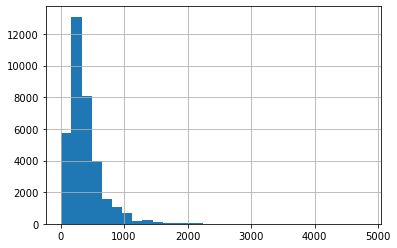

In [7]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
# seq_len_b = [len(i.split()) for i in train_body]

pd.Series(seq_len).hist(bins = 30)

In [8]:
max_seq_len = 512

In [14]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    padding='max_length',
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    padding='max_length',  
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)



In [19]:
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    padding='max_length',
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Convert Integer Sequences to Tensors

In [15]:
# for train set

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])

train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())



In [20]:
# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [16]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [22]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = RandomSampler(test_data)

# dataLoader for train set
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


# Freeze BERT Parameters

In [11]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [11]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer

      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,4)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
      # print(sent_id.size())
      # print(mask.size())
      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [12]:
# pass the pre-trained BERT to our define architecture
device = torch.device("cuda")
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [77]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# Find Class Weights

In [25]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', classes = np.unique(train_labels), y =train_labels)

print(class_wts)

[3.33877628 9.11321721 1.42312    0.34625117]


In [26]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

# Fine-Tune BERT

In [82]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch
    # print(sent_id)

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)
    #print("Predicted val: {}".format(preds))
   

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [83]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [84]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of  1,094.
  Batch   100  of  1,094.
  Batch   150  of  1,094.
  Batch   200  of  1,094.
  Batch   250  of  1,094.
  Batch   300  of  1,094.
  Batch   350  of  1,094.
  Batch   400  of  1,094.
  Batch   450  of  1,094.
  Batch   500  of  1,094.
  Batch   550  of  1,094.
  Batch   600  of  1,094.
  Batch   650  of  1,094.
  Batch   700  of  1,094.
  Batch   750  of  1,094.
  Batch   800  of  1,094.
  Batch   850  of  1,094.
  Batch   900  of  1,094.
  Batch   950  of  1,094.
  Batch 1,000  of  1,094.
  Batch 1,050  of  1,094.

Evaluating...
  Batch    50  of    235.
  Batch   100  of    235.
  Batch   150  of    235.
  Batch   200  of    235.

Training Loss: 1.380
Validation Loss: 1.317

 Epoch 2 / 10
  Batch    50  of  1,094.
  Batch   100  of  1,094.
  Batch   150  of  1,094.
  Batch   200  of  1,094.
  Batch   250  of  1,094.
  Batch   300  of  1,094.
  Batch   350  of  1,094.
  Batch   400  of  1,094.
  Batch   450  of  1,094.
  Batch   500  of  1,094.


# Load Saved Model

In [13]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [28]:
# function for evaluating the model
def evaluate_test():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(test_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(test_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [29]:
_,total_pred = evaluate_test()


Evaluating...
  Batch    50  of    120.
  Batch   100  of    120.


In [38]:
print(total_pred.shape)

(3812, 4)


In [45]:
# model's performance
preds = np.argmax(total_pred, axis = 1)
test_y_array = test_y.detach().cpu().numpy()
print(classification_report(test_y_array, preds))
# confusion matrix
pd.crosstab(test_y_array, preds)

              precision    recall  f1-score   support

           0       0.08      0.15      0.10       285
           1       0.02      0.02      0.02       104
           2       0.19      0.41      0.26       670
           3       0.72      0.45      0.55      2753

    accuracy                           0.41      3812
   macro avg       0.25      0.26      0.23      3812
weighted avg       0.56      0.41      0.45      3812



col_0,0,1,2,3
row_0,,,,
0,43,7,95,140
1,12,2,38,52
2,89,15,274,292
3,425,66,1024,1238


In [ ]:
# get predictions for test data

with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)